# Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning taught at EPFL in Spring 2024 by Prof. Volkan Cevher

In [40]:
import os
from typing import List
from tqdm import tqdm

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dynamic Programming exercise

We will make use of the operators introduced in the slides of lectures 1 and 2. 
$(T V)(s)$, $\mathcal{G}$ and $T^{\pi}$

Before diving into the implementation of Value Iteration or Policy Iteration, we instantiate an environment using the library in the foilder `src`.

The gridworld environment is instantiated via the class `GridWorldEnvironment`. It takes 4 input values:

- `reward_mode` : integer between 0 and 3 for different reward profiles
- `size`: Gridworld size
- `prop`: probability assigned to the event that the agent do not follow the chosen action but another one selected uniformely at random.
- `gamma`: the discount factor of the environment.

In [2]:
reward_mode = 2 # put an image to show which is the reward
size = 10 
prop = 0
gamma=0.99 # rename discount_factor
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

Below, we illustrate how to access the gridworld environment, i.e. how to access the reward, the transition matrix and the discount factor.

In [3]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
print(gridworld_example.n_states)
print(gridworld_example.n_actions)
print(gridworld_example.r)
print(gridworld_example.gamma)
print(type(gridworld_example.sparseT[0]), gridworld_example.sparseT[0])

9
4
[[   0.    0.    0.    0.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]]
0.99
<class 'scipy.sparse._csr.csr_matrix'>   (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (4, 1)	1.0
  (5, 2)	1.0
  (6, 3)	1.0
  (7, 4)	1.0
  (8, 5)	1.0


***Interface with a Gridworld instance***
- `print(gridworld.n_states)` #return the number of states
- `print(gridworld.n_actions)` #return the number of actions
- `print(gridworld.r)` #return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` #Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.



<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

Then we set up the solver object that will implement the routine needed to evaluate the value of the produced policies

In [4]:
solver = MDPsolver(gridworld)

We will use this solver to compute the optimal value function to measure the suboptimality of the policies produced by value iteration or policy iteration.

To access the optimal value function use `solver.v`.

In [5]:
solver.value_iteration()

## Ex 1: Value Iteration [25 pts.]

### 1.1 Implement value iteration

In [6]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """
    policies = []
    vs = []
    v = np.zeros(env.n_states) # initialize value function
    q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
    
    while True:
        v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
        for a in range(env.n_actions):
            #Calculate the Q-value according to the State-Action Value Function
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v_old) # calculate Q-value
        #We can calculate the optimal value function by taking the maximum Q-value
        #This comes from the Bellman Optimality Condition 
        v = np.max(q, axis=1) # update value function
        #THis again comes from the Bellman Optimality Condition. We find the policy by taking the 
        #argmax of Q over the actions. (ie the greedy policy).
        #At the fixed point we should not move away from the optimal policy even if we take greedy
        #actions and so we can do this.
        policies.append(np.argmax(q, axis=1)) # obtain policy
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
    return policies, vs

In [7]:
policies, vs = value_iteration(gridworld)

### 1.2: Evaluate the extracted policies

For the evaluation of the sequence of policies, i.e. computing $V^\pi$ for each policy $\pi$ we recall that $V^\pi$ is the fixed point $V^\pi = T^\pi (V^\pi)$.
In the following code, we ask you to apply the operator $T^\pi$ a number of time sufficient to find a value $V$ such that $ || T^\pi(V) - V || \leq \mathrm{tol}$

In [8]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:, a] + env.gamma*env.sparseT[a].dot(v_old) #calculate Q-value
            for s in range(env.n_states):
                action_taken = pi[s] # obtain the action determined by the policy
                v[s] = q[s,action_taken] #calculate value function by $v(s) = Q(s,pi(s))$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [9]:
print(f"The number of policies iterated on: {len(policies)}")
values = evaluate_policy_sequence(policies, gridworld)
print(f"The length of values: {len(values)}")
print(f"The length of an element of values: {len(values[0])}")

The number of policies iterated on: 21
The length of values: 21
The length of an element of values: 100


### 1.3: Plot the results 

Plot using the method ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False) ```

Compute both the iterates $V_t$ produced by value iteration and the value function achieved by the extracted policies $V^{\pi_t}$ with $\pi_t = \mathcal{G}(V_t)$. What do you observe ?


In [10]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])
    return np.array(subopts)

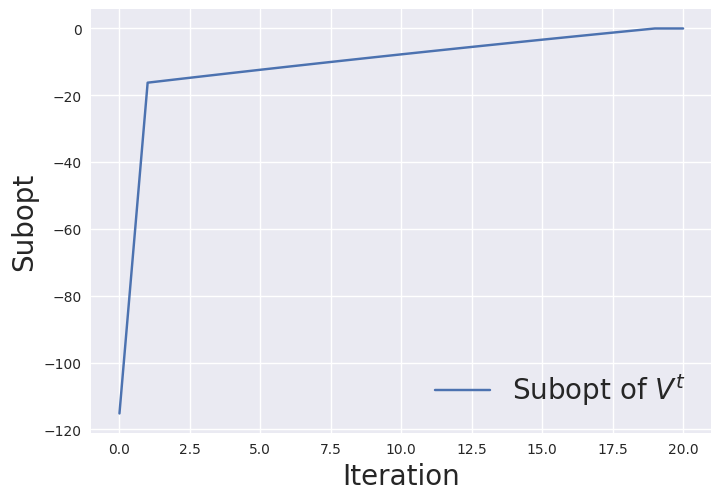

In [11]:
plot_lines([compute_subopt(vs, solver.v)], [r"Subopt of $V^t$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

**Answers**

### Proving T is a contraction
We will now prove that the Bellman operator $\mathcal{T}$ is a $\gamma$-contraction operator. We begin with any two values functions $V$ and $V^\prime$ and set up the equation:
$$
\begin{align*}
    \left | (\mathcal{T}V)(s) - \mathcal{T}V^{\prime}(s) \right |
\end{align*}
$$
Next we substitute the definition of the Bellman operator into the equation above to get:

$$
\begin{align*}
    \left | \underset{a \in \mathcal{A}}{\operatorname{max}}\left \{ \left[ r(s, a) + \gamma \sum_{s^{\prime} \in \mathcal{S}} P(s^{\prime} | s, a)V(s^{\prime}) \right ] \right\}  - \underset{a^{\prime} \in \mathcal{A}}{\operatorname{max}}\left \{ \left [ r(s, a^{\prime}) + \gamma \sum_{s^{\prime} \in \mathcal{S}} P(s^{\prime}|s, a))V^{\prime}(s^{\prime}) \right ] \right \} \right |
\end{align*}
$$

Since we are maximising over the same set of actions we can make use of this inequality for the max function:
$$
\left | \underset{x \in \mathcal{X}}{\operatorname{max}}\{ f(x) \} - \underset{x \in \mathcal{X}}{\operatorname{max}}\{ g(x) \}    \right | \leq \underset{x \in \mathcal{X}}{\operatorname{max}}\{\left | f(x) - g(x)\right | \}
$$

Applying this to the equation above we get:
$$
\begin{align*}
    &\underset{a \in \mathcal{A}}{\operatorname{max}}\left \{ \left | r(s, a) + \gamma \sum_{s^{\prime} \in \mathcal{S}} P(s^{\prime}| s, a)V(s^{\prime}) - r(s, a) - \gamma \sum_{s^{\prime} \in \mathcal{S}}P(s^{\prime}| s, a)V^{\prime}(s^{\prime}) \right | \right \} \\
    &=\underset{a \in \mathcal{A}}{\operatorname{max}}\left\{ \left | \gamma\sum_{s^{\prime} \in \mathcal{S}}P(s^{\prime}|s, a) (V(s^{\prime}) - V^{\prime}(s^{\prime})) \right | \right\}\\
    &\leq \underset{a \in \mathcal{A}}{\operatorname{max}}\left\{\gamma\sum_{s^{\prime} \in \mathcal{S}}P(s^{\prime}|s, a) \left | V(s^{\prime}) - V^{\prime}(s^{\prime}) \right | \right\} \\
    &\leq \underset{a \in \mathcal{A}}{\operatorname{max}}\left\{\gamma\sum_{s^{\prime} \in \mathcal{S}}P(s^{\prime}|s, a) \sum_{s^{\prime} \in \mathcal{S}} \left | V(s^{\prime}) - V^{\prime}(s^{\prime}) \right | \right\} \\
    &\leq \underset{a \in \mathcal{A}}{\operatorname{max}}\left\{\gamma\sum_{s^{\prime} \in \mathcal{S}}P(s^{\prime}|s, a) \right\} \operatorname{max}\left\{\sum_{s^{\prime} \in \mathcal{S}} \left | V(s^{\prime}) - V^{\prime}(s^{\prime}) \right | \right\} \\
    &\leq \underset{a \in \mathcal{A}}{\operatorname{max}}\left\{\gamma\sum_{s^{\prime} \in \mathcal{S}}P(s^{\prime}|s, a) \right\} \lVert V(s^{\prime}) - V^{\prime}(s^{\prime}) \rVert_{\infty} \\
    &=\gamma \lVert V(s^{\prime}) - V^{\prime}(s^{\prime}) \rVert
\end{align*}
$$
Since $\gamma \in [0, 1]$ we have that the Bellman operator is a contraction operator.


### Why the iterates are an upper bound
To answer the second question be begin by noticing that the Bellman operator is component-wise monotonic, that is to say if $V \leq V^{\prime}$ then $\mathcal{T}V \leq \mathcal{T}V^{\prime}$. We also must use the fact that the $\mathcal{T}$ is a contraction operator. If we start with a $V_{0}$ that is higher than $V^{\star}$ which is our optimal, then we will approach $V^{\star}$ from above meaning that value iteration is an upper bound to $V^{\star}$. This can happen because the $V$ that we initialize the algorithm with doesn't necessairly correspond to a particular policy and as such can be higher than the $V^{\star}$.


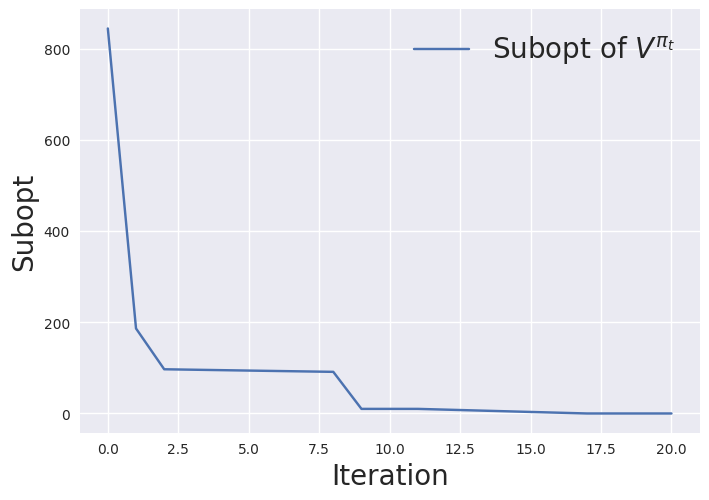

In [12]:
plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

To better appreciate the difference in the convergence plot use log scale.

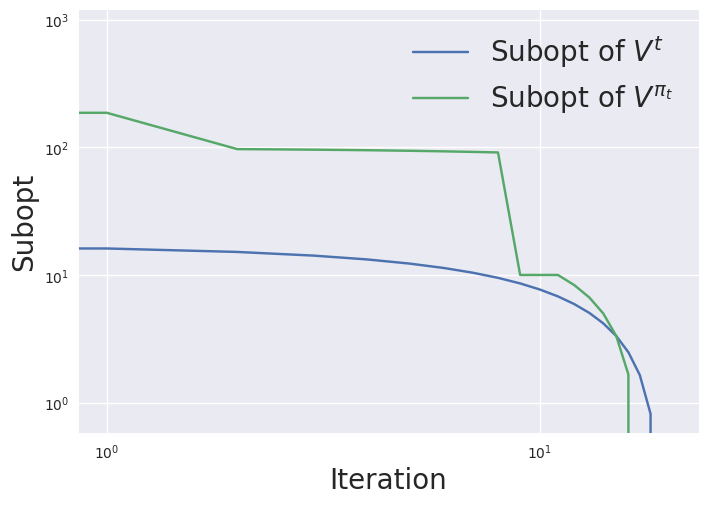

In [13]:
plot_log_lines([-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)], 
               [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"], 
               ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

# Ex 2: Policy Iteration [25 pts.] (Double check the implimentations of these functions)

In [14]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + gamma*env.sparseT[a].dot(v_old)
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [15]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = []
    for s in range(q.shape[0]):
        policy.append(np.argmax(q[s, :]))
    return policy

In [16]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env, tol)
        pi = get_greedy_policy(q)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs, pi

In [17]:
values_pi, _ = policy_iteration(gridworld)
print(values_pi)

[array([   0.        , -100.        , -100.        , -100.        ,
       -100.        , -100.        , -100.        , -100.        ,
       -100.        , -100.        ,   -1.        , -100.        ,
       -100.        , -100.        , -199.        , -199.        ,
       -100.        , -100.        , -100.        , -100.        ,
         -1.99      , -100.        , -100.        , -100.        ,
       -297.01      , -297.01      , -100.        , -100.        ,
       -100.        , -100.        ,   -2.9701    , -100.        ,
       -100.        , -100.        , -394.0399    , -394.0399    ,
       -100.        , -100.        , -100.        , -100.        ,
         -3.940399  , -199.        , -199.        , -199.        ,
       -490.099501  , -490.099501  , -199.        , -199.        ,
       -199.        , -100.        ,   -4.90099501, -297.01      ,
       -297.01      , -297.01      , -585.19850599, -585.19850599,
       -297.01      , -297.01      , -297.01      , -100.    

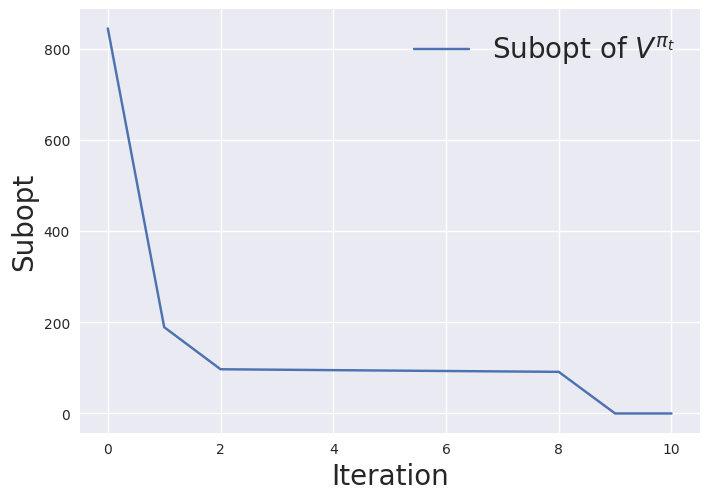

In [18]:
plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

### Compare with Value Iteration

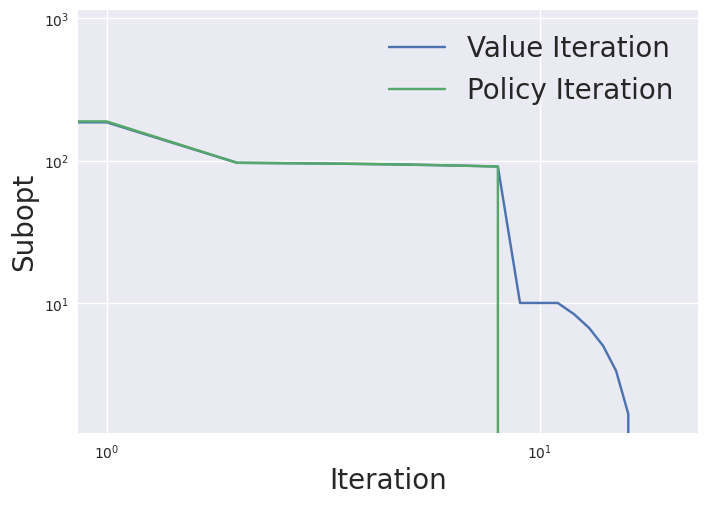

In [19]:
plot_log_lines([compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)], 
               ["Value Iteration", "Policy Iteration"], 
               ["Iteration", "Subopt"], "figs", "VIvsPI.pdf", show = True)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***

1) The Policy Iteration algorithm converges faster in my testing

2) For value iteration we expect to converge in $\mathcal{O}(\frac{\operatorname{log}(\epsilon(1-\gamma))}{\operatorname{log}\gamma})$ and for policy iteration we expect to converge in $\mathcal{O}(\frac{\lvert \mathcal{S} \rvert (\lvert \mathcal{A} \rvert - 1)}{1-\gamma})$. Theoretically, given the number of states and actions we have, Value iteration should converge faster than policy iteration. But this is not what we see.

***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

### Policy Improvement Theorem Proof
This theorem states that if we are in a state $s$ under a policy $\pi$ and then we take another action $\pi^{\prime}(s))$ that increases $Q^{\pi}$ then we also improve on $V^{\pi}$. 

Assume:
$$
\begin{align*}
    V^{\pi}(s) &\leq Q^{\pi}(s, \pi^{\prime}(s)) \\
               &= \mathbb{E}_{a \sim \pi^{\prime}}[r + \gamma V^{\pi}(s')] \\
\end{align*}
$$

Now we can replace $V^{\prime}(s')$ with $Q^{\pi}(s', \pi^{\prime}(s'))$. We choose $\pi^{\prime}$ such that $Q^{\pi}(s', \pi^{\prime}(s'))$ is bigger than $V^{\pi}(s')$ (as was stated before) we get:

$$
\begin{align*}
    &=\mathbb{E}_{a \sim \pi^{\prime}}[r(s,a) + \gamma V^{\pi}(s')] \\
    &\leq \mathbb{E}_{a \sim \pi^{\prime}}[r(s,a) + \gamma Q^{\pi}(s', \pi^{\prime}(s'))] \\
    &=\mathbb{E}_{a \sim \pi^{\prime}}[r(s,a) + \gamma r(s',a') + \gamma^2 V^{\pi}(s'')] \\
    &\leq \cdots \\
    &\leq \mathbb{E}_{a \sim \pi^{\prime}}[r(s,a) + \gamma r(s', a') +\gamma^2 r(s'', a'') + \cdots ] \\
    &= V^{\pi^{\prime}}(s)
\end{align*}
$$

And so we have shown that $V^{\pi^{\prime}}(s) \geq V^{\pi}(s)$. Proving the Policy Improvement Theorem.


### Bellman Operator Monotonicity
We want to prove that the Bellman operator is monotone elementwise. That is if $V \geq V'$, then for any $\pi$, $\mathcal{T}_{\pi}(V') \leq \mathcal{T}_{\pi}(V)$. We assume $V, V' \in \mathbb{R}^{\lvert \mathcal{S} \rvert}$, $\pi \in \Pi$ and $R^{\pi}, P^{\pi} \in \mathbb{R}^{\lvert \mathcal{S} \rvert \times \lvert \mathcal{A} \rvert}$

$$
\begin{align*}
    \lVert \mathcal{T}_{\pi}(V) - \mathcal{T}_{\pi}(V') \rVert_{\infty} &= \lVert R^{\pi} + \gamma P^{\pi} V - R^{\pi} - \gamma P^{\pi} V' \rVert_{\infty} \\
    &= \gamma\lVert P^{\pi}(V-V') \rVert_{\infty} \\
    &\text{ Since P is stochastic } \lVert Px \rVert_{\infty} \leq \lVert x \rVert_{\infty} \\
    &\leq \gamma \lVert V - V' \rVert_{\infty}  
\end{align*}
$$

Hence when we have $V' \leq V$ then $\mathcal{T}_{\pi}(V') \leq \mathcal{T}_{\pi}(V)$

# Ex 3: Modified Policy Iteration [25 pts.]

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

For $m=1$ we will recover value iteration. For $m=\infty$ we will recover policy iteration

First, write a function that applies the Bellman evaluation operator $m$ times

In [20]:
def policy_operator_m_times(pi, m, env, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v: initial value vector
        q: initial state action value vector
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    i = 0
    while i < m:
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma*env.sparseT[a].dot(v)	
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]
        i = i + 1
    return v, q

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [21]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)
        v, q = policy_operator_m_times(pi, m, env, v, q)
        policies.append(pi)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [22]:
m_values = ["1", "2", "3", "5", "10", "20"]
to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi=modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

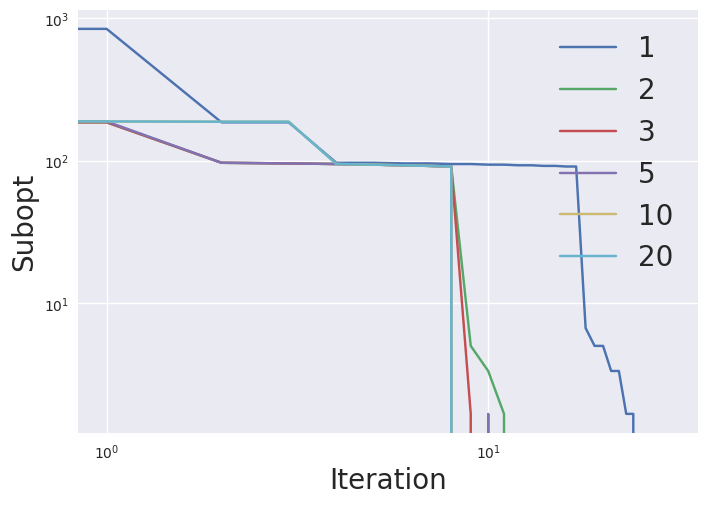

In [23]:
plot_log_lines(to_plot, 
           m_values, 
           ["Iteration", "Subopt"], "figs", "MPI.pdf", show = True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

1) From the graph it seems that the larger $m$ is the quicker convergence is reached.
2) The cost per iteration of MPI is $\mathcal{O}(m\lvert S \rvert^2 + \lvert S \rvert^2 \lvert A \rvert)$. 
3) The cost will be $\mathcal{O}(\lvert S \rvert^3 + \lvert S \rvert^2 \lvert  A \rvert)$. The $\lvert S \rvert^3$ cost comes from the need to perform a matrix inversion (assuming a naive method and there is no structure in the matrix to exploit)

# Ex 4: Q-Learning [15 pts.]

Now, we are ready to tackle the problem in the model free setting. For technical reason, we focus on the finite horizon setting in this part and we compare two exploration strategies.
1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

For other technical reason, we also need to rescale the reward between 0 and 1, as done in the following

In [26]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### Q learning with epsilon greedy 

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [27]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [28]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = (1-alpha)*Q[h, state, a] + alpha*(rewards[-1] + V[h+1, new_state])

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

In [29]:
reward_eps_greedy = q_learning_epsilon_greedy()  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [30]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = (1-alpha)*Q[h, state, a] + alpha*(rewards[-1] + V[h+1, new_state] + bonus)

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [31]:
reward_UCB = q_learning_ucb_bonuses()  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

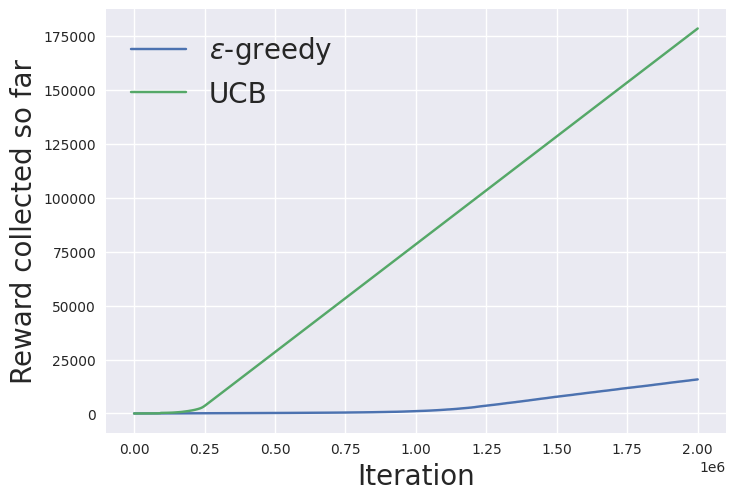

In [37]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],
    [r"$\epsilon$-greedy", "UCB"],
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=False
)

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?

**Answer**

Let's set up the problem. At the begining of the first episode we initalize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$. Essentially weighting all actions-state pairs and states the same value. It should also be noted that the reward is 0 for all states except staying in the right-most state. So for the majority of the time the reward will be 0, meaning that the algorithm will not make any meaningful updates to $Q_h(x, a)$. Essentially each state-action pair evaluated will have the same value. So this problem boils down to a random walk with restart problem, where at each state we have the option of moving to the right with probability $\frac{1}{2}$ and going back to the begining with probability $\frac{1}{2}$. 

There are 3 main cases in this problem. 
 1) The first case is when $H < N$. In this case, even with the best policy, we have 0 probability of getting the reward. 
 2) In the case where $H=N$ we need to take $N-1$ steps to the right to reach the final state and then one more step to actually get the reward. The probability of this happening is $\frac{1}{2^N}$.
 3) In the case where $H \geq N$ we will first have to construct the transition probability matrix of the system. The matrix $P$ will be defined as $P(i, j) = \alpha$ where $\alpha$ is the probability to transition from state $i$ to $j$. We then compute $P^H$ and compute the entry $P(1, N)$ will give the probability of raching state $N$

**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.

Yes the emperical result does match the theoretical result described by Jin et al. 2018. In the model free case, when Q is zero initialized they state that the regret obtained by $\epsilon$-greedy algorithm is $\mathcal{O}(\operatorname{min}\{T, A^{\frac{H}{2}}\})$ whereas the regret for the UCB-B algorithim is $\mathcal{O}{\sqrt{H^3SAT}}$ where $H$ is the number of steps per episode, $S$ is the number of states, $A$ is the number of actions and T is the overall number of steps, i.e $KH$. If we assume large $T$, then asymtotically the regret for UCB-B grows at a rate of $\sqrt{T}$ whereas the regret for for $\epsilon$-greedy grows with $T$. Implying that UCB-B will pick up rewards faster than $\epsilon$-greedy

## Monte Carlo (MC) and Time Differences (TD) ( * Question ) [25 points]

Disclaimer: The TA can not help you on this part of the notebook.

In [33]:
def generate_episode(policy: List, H: int, initial_state: int):
    """
    Generate an episode using the given policy.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param H: Maximum number of steps in the episode.
    :param initial_state: Starting state.

    :return: A list of (state, action, reward) tuples.
    """
    episode = []
    state = initial_state
    for _ in range(H):
        action = policy[state]
        reward = gridworld.r[state, action]
        next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Monte Carlo policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        episode = generate_episode(policy, H, initial_state=99)  # Generate episode
        G = 0  # Return

        # Backward pass through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, _, reward = episode[t]
            G = gamma * G + reward  # Discounted return

            # Update theta using gradient descent
            phi_s = phi[state]  # Feature vector for the current state
            V_hat = np.dot(theta, phi_s)  # Current value estimate
            theta += -alpha * (V_hat - G) * phi_s  # Gradient descent update

    return theta


In [38]:

import numpy as np
def td_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Temporal Difference (TD) policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        state = 99  # Initial state
        for _ in range(H):  # Step loop
            # Sample action from policy
            action = policy[state]
            reward = gridworld.r[state, action]
            next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])

            # Compute TD target and TD error
            phi_s = phi[state]  # Feature vector for current state
            phi_s_next = phi[next_state]  # Feature vector for next state
            V_s = np.dot(theta, phi_s)  # Current value estimate
            V_s_next = np.dot(theta, phi_s_next)  # Next value estimate
            td_target = reward + gamma * V_s_next  # TD target
            td_error = (V_s - td_target)  # TD error

            # Update theta using gradient descent
            theta += -alpha * td_error * phi_s

            # Move to the next state
            state = next_state

    return theta

**Case 1:**

In [41]:


_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 1000/1000 [00:42<00:00, 23.80it/s]


8.919948611419325e-07


**Case 2:**

In [42]:
_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
phi[:50,:]*=0

# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 1000/1000 [00:42<00:00, 23.49it/s]

190.43020836185028


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 1?
- Explain your answer writing down the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case. To give this answer you can assume that $\rho$ is positive everywhere.

**Answers**


In case 1 the solution does coincide up to a numerical error.

The analytical solution of the optimal solutions of the Monte Carlo optimization problem:
$$
\begin{align}
    \theta^\star_{MC} &= \underset{\theta}{\operatorname{argmin}}\{\mathbb{E}\left[(G_t - \phi(s)^{\top}\theta)^2\right] \}\\
    V ^{\pi}&= R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \cdots
\end{align}
$$
is given by:
$$
\begin{align}
    \theta^\star_{MC} &= (\Phi^{\top}\operatorname{diag}(\rho)\Phi)^{-1}\Phi^{\top}\operatorname{diag}(\rho)V^{\pi}\\
\end{align}
$$
where $\Phi$ is the $S \times d$ feature matrix.

The analytical solution of the optimal solutions of the TD optimization problem:
$$
\begin{align}
    \theta^\star_{TD} &= \underset{\theta}{\operatorname{argmin}}\{\mathbb{E}\left[(r + \gamma \phi(s')^{\top}\theta - \phi(s)^{\top}\theta)^2\right] \}\\
\end{align}
$$
is given by:
$$
\begin{align}
    \theta^\star_{TD} &= (\Phi^{\top}\operatorname{diag}(\rho)\Phi)^{-1}\Phi^{\top}\operatorname{diag}(\rho)\mathcal{T}^{\pi}\Phi\theta^\star_{TD}\\
\end{align}
$$

The two solutions agree to numerical accuracy in case 1 since out LFA is a good approximation of the true value function.So $\mathcal{T}^{\pi}\Phi\theta^\star_{TD} \approx V^{\pi}$ and so the two soltuions coincide with each other.


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 2?
- Explain your answer leveraging the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case.

In case 2 the solution does not coincide up to numerical precision. They are greatly different. This is due to the fact that the LFA is not a good approximation of the true value function due to the fact that we set the first 50 rows of the feature matrix to zero. In this case $\mathcal{T}^{\pi}\Phi\theta^\star_{TD}$ does not approximate $V^{\pi}$ well and so the two solutions differ from each other. Another way one can look at it is that the projection of $V^{\pi}$ that we get from Monte Carlo is different than the $V^{\pi}$ that the projected bellman operator in Temporal Differences will give us.